In [2]:
from qiskit import transpile
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.sparse import diags

from linear_solvers import NumPyLinearSolver, HHL
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from qiskit.quantum_info import Statevector
import sys
import os
os.environ["Q_ALCHEMY_API_KEY"] = "JnvkpMCsyr4nB9nHcwa6CbxqhtZXyF1b"
sys.path.append('..')
from q_alchemy.qiskit import QAlchemyInitialize
from qiskit.opflow import (
    Z,
    I,
    StateFn,
    TensoredOp,
    ExpectationBase,
    CircuitSampler,
    ListOp,
    ExpectationFactory,
    ComposedOp,
)




In [4]:
def calculate_norm(qc: QuantumCircuit, nb: int, nl: int, na:int) -> float:
        """Calculates the value of the euclidean norm of the solution.

        Args:
            qc: The quantum circuit preparing the solution x to the system.

        Returns:
            The value of the euclidean norm of the solution.
        """

        # Create the Operators Zero and One
        zero_op = (I + Z) / 2
        one_op = (I - Z) / 2

        # Norm observable
        observable = one_op ^ TensoredOp((nl + na) * [zero_op]) ^ (I ^ nb)
        norm_2 = (~StateFn(observable) @ StateFn(qc)).eval()
        

        return np.real(np.sqrt(norm_2))

In [60]:
def get_solution_vector(solution, length):
    raw_solution_vector = Statevector(solution.state)
    numq = solution.state.num_qubits
    n = 2**(numq-1)
    print(raw_solution_vector)
    solution_vector = Statevector(solution.state).data[n:n+length].real
    print(solution_vector)
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)

In [6]:
import re

def ibm_decompose(qc):
    state_inst = qc.data[0]
    qubit = str(state_inst[1][0])
    name = re.findall(r"'([^']*)'", qubit)[0]
    qr = QuantumRegister(3, name)
    qc_raw = QuantumCircuit(qr)
    qc_raw.data = [state_inst]
    qc = transpile(qc_raw, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc
    

In [7]:
def q_alchemy_prep(b, fid_loss):
    sp_org = QAlchemyInitialize(b, opt_params={f'max_fidelity_loss':fid_loss})
    qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc

In [8]:
def circuit_depth_generator(b, fid_loss):
    qc = q_alchemy_prep(b, fid_loss)
    depth = qc.depth()
    return depth

In [72]:
def answer_comparison(x1, x2):
    dot_product = np.dot(x1, x2)
    norm1 = np.linalg.norm(x1)
    norm2 = np.linalg.norm(x2)
    
    cosine_similarity = dot_product/(norm1*norm2)
    angle_diff = np.arccos(cosine_similarity)
    
    diff = (x1-x2)
    norm_diff = np.linalg.norm(diff)
    return angle_diff, norm_diff

## Comparing the circuit depth
Define Matrices and solutions

In [19]:
b_path = 'hhl_data/trial_solution.npy'
data_path = 'hhl_data/hhl_qalchemy_results_0.01.csv'

b = np.loadtxt(b_path)


A = np.array([[1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [2.0, 3.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [3.0, 4.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 8.0, 9.0, 0.0, 10.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.0, 12.0]])
ibm = HHL().solve(A, b)
ibm.state.draw()


/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


┌─────────────────┐┌───────┐        ┌──────────┐
q13809_0: ┤0                ├┤9      ├────────┤9         ├
          │                 ││       │        │          │
q13809_1: ┤1 circuit-134893 ├┤10     ├────────┤10        ├
          │                 ││       │        │          │
q13809_2: ┤2                ├┤11     ├────────┤11        ├
          └─────────────────┘│       │┌──────┐│          │
q13810_0: ───────────────────┤0      ├┤8     ├┤0         ├
                             │       ││      ││          │
q13810_1: ───────────────────┤1      ├┤7     ├┤1         ├
                             │       ││      ││          │
q13810_2: ───────────────────┤2      ├┤6     ├┤2         ├
                             │   QPE ││      ││   QPE_dg │
q13810_3: ───────────────────┤3      ├┤5     ├┤3         ├
                             │       ││      ││          │
q13810_4: ───────────────────┤4      ├┤4     ├┤4         ├
                             │       ││  1/x ││          │
q13810_5: ───────────────────┤5      ├┤3     ├┤5         ├
                             │       ││      ││          │
q13810_6: ───────────────────┤6      ├┤2     ├┤6         ├
                             │       ││      ││          │
q13810_7: ───────────────────┤7      ├┤1     ├┤7         ├
                             │       ││      ││          │
q13810_8: ───────────────────┤8      ├┤0     ├┤8         ├
                             └───────┘│      │└──────────┘
  q13811: ────────────────────────────┤9     ├────────────
                                      └──────┘

### IBM's state preparation circuit

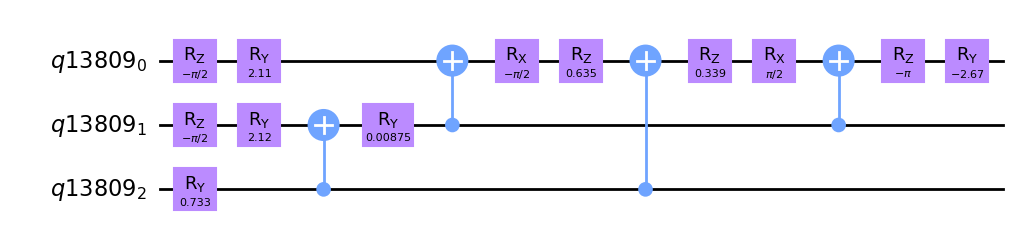

In [20]:
ibm_state = ibm_decompose(ibm.state)
ibm_state.draw('mpl')


### Q-alchemy's state preparation circuit

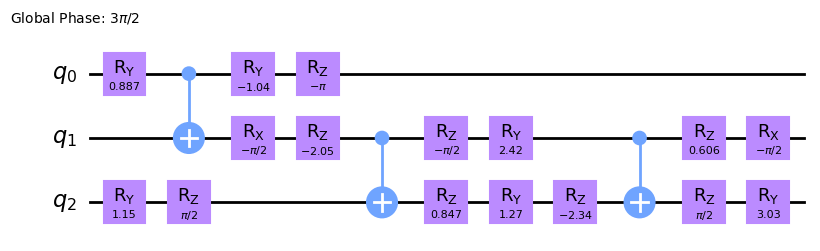

In [21]:
q_alchemy = q_alchemy_prep(b, 0.0)
q_alchemy.draw('mpl')

### Comparing circuit depth

In [22]:
ibm_depth = ibm_state.depth()
qal_depth = q_alchemy.depth()

print(f'IBM circuit depth: {ibm_depth}')
print(f'Q-Alchemy circuit depth: {qal_depth}')

IBM circuit depth: 13
Q-Alchemy circuit depth: 11


### Benchmarking

In [23]:
classical_solution = NumPyLinearSolver().solve(A, b)

In [24]:
import pandas as pd

df = pd.read_csv(data_path, index_col=0)
qal_norms = df['norms'].values
qal_fids = df['fid_loss'].values
ibm_norms = [ibm.euclidean_norm] * len(qal_norms)
classical_norms = [classical_solution.euclidean_norm]*len(qal_norms)

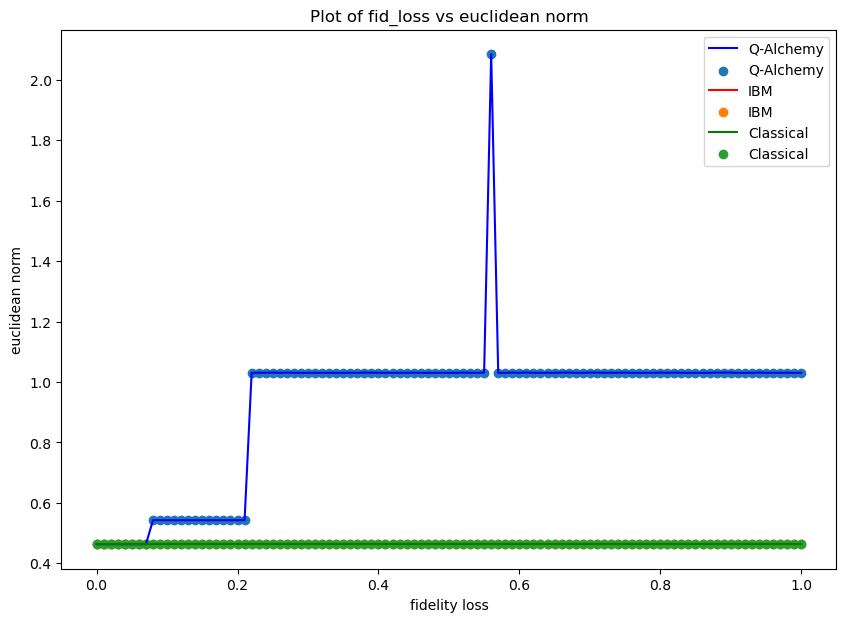

In [25]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, qal_norms, color='blue', label='Q-Alchemy')
plt.scatter(qal_fids, qal_norms, label='Q-Alchemy')

plt.plot(qal_fids, ibm_norms, color='red', label='IBM')
plt.scatter(qal_fids, ibm_norms, label='IBM')

plt.plot(qal_fids, classical_norms, color='green', label='Classical')
plt.scatter(qal_fids, classical_norms, label='Classical')

plt.xlabel('fidelity loss')
plt.ylabel('euclidean norm')
plt.title('Plot of fid_loss vs euclidean norm')
plt.legend()
plt.show()

In [26]:
qal_depths = [circuit_depth_generator(b, fid_loss) for fid_loss in qal_fids]



/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


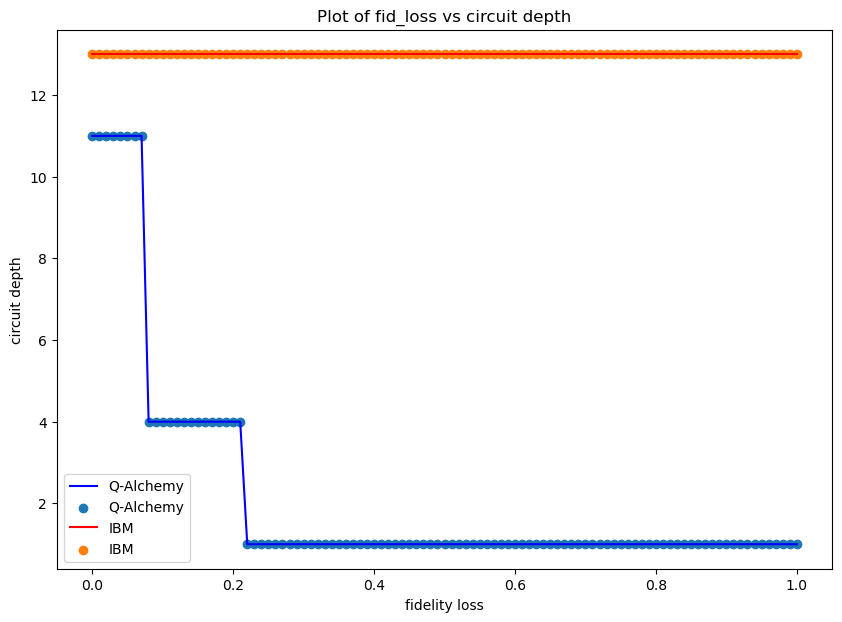

In [27]:
fig: Figure = plt.figure(figsize =(10, 7))

ibm_depths = [ibm_depth]*len(qal_fids)

plt.plot(qal_fids, qal_depths, color='blue', label='Q-Alchemy')
plt.scatter(qal_fids, qal_depths, label='Q-Alchemy')

plt.plot(qal_fids, ibm_depths, color='red', label='IBM')
plt.scatter(qal_fids, ibm_depths, label='IBM')

plt.xlabel('fidelity loss')
plt.ylabel('circuit depth')
plt.title('Plot of fid_loss vs circuit depth')
plt.legend()
plt.show()

In [55]:
df = pd.read_csv(data_path, index_col=0)
len(df['solution'])

101

In [56]:
import ast
import numpy as np

qal_solution = []
for i in range(len(df['solution'])):
    str_array = df['solution'][i]
    cleaned_str = str_array.replace('array(', '').replace('(', '').replace(')', '').replace('\n', '')
    
    evaluated_list = ast.literal_eval(cleaned_str)

    numpy_array = np.array(evaluated_list)
    array = numpy_array.reshape(8)
    qal_solution.append(array)
    
print(len(qal_solution))


101


In [73]:
norm_ibm_diffs = []
angle_ibm_diffs = []

norm_classical_diffs = []
angle_classical_diffs = []

ibm_solution = default_sol = get_solution_vector(ibm, 8)


for i in range(len(qal_solution)):
    angle_ibm, norm_ibm = answer_comparison(qal_solution[i], ibm_solution)
    angle_classical, norm_classical = answer_comparison(qal_solution[i], classical_solution.state)
    
    norm_ibm_diffs.append(norm_ibm)
    angle_ibm_diffs.append(angle_ibm)
    
    norm_classical_diffs.append(norm_classical)
    angle_classical_diffs.append(angle_classical)
    

/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Statevector([ 2.18600800e-01-1.36086349e-15j,
              3.75735328e-01-1.38588147e-13j,
              7.94636206e-01-4.43396050e-13j, ...,
             -3.33450187e-17-1.11920443e-05j,
              3.03689319e-17+1.14166954e-05j,
              7.32188994e-18+5.76539853e-06j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
[ 0.08551378 -0.03352393  0.00357725  0.00401697  0.00026832  0.00299444
 -0.00253723  0.00272855]


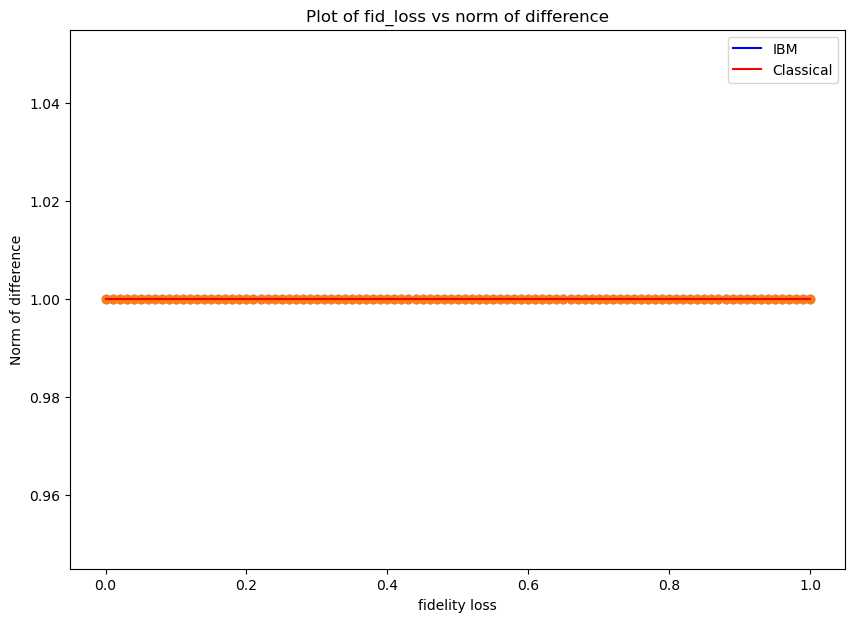

In [74]:
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, norm_ibm_diffs, color='blue', label='IBM')
plt.scatter(qal_fids, norm_ibm_diffs)

plt.plot(qal_fids, norm_classical_diffs, color='red', label='Classical')
plt.scatter(qal_fids, norm_classical_diffs)

plt.xlabel('fidelity loss')
plt.ylabel('Norm of difference')
plt.title('Plot of fid_loss vs norm of difference')
plt.legend()
plt.show()

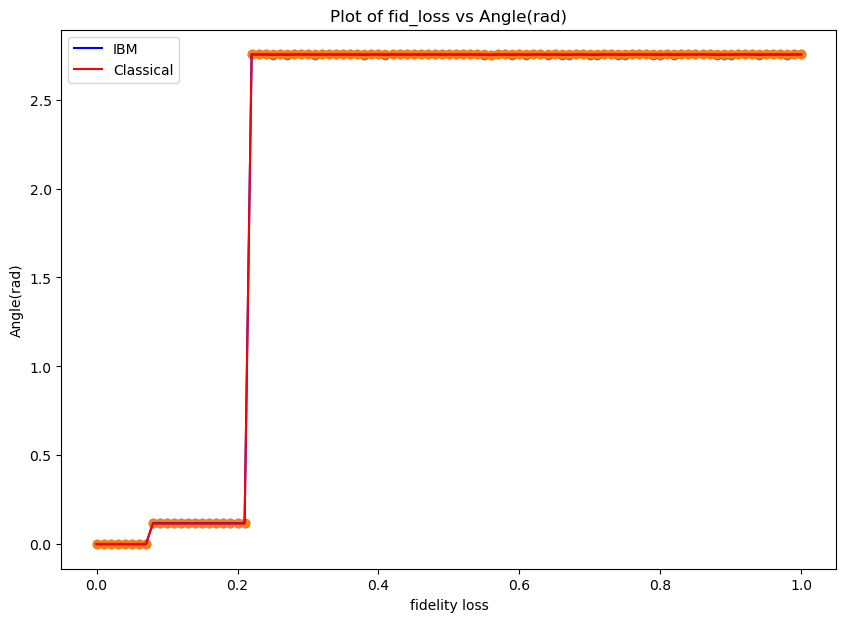

In [75]:
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, angle_ibm_diffs, color='blue', label='IBM')
plt.scatter(qal_fids, angle_ibm_diffs)

plt.plot(qal_fids, angle_classical_diffs, color='red', label='Classical')
plt.scatter(qal_fids, angle_classical_diffs)

plt.xlabel('fidelity loss')
plt.ylabel('Angle(rad)')
plt.title('Plot of fid_loss vs Angle(rad)')
plt.legend()
plt.show()

In [71]:
print(qal_solution[-1])
print(ibm_solution)

[-0.76632306  0.67212685 -0.06826459  0.12824411  0.02449324 -0.00999026
  0.02452421 -0.00547588]
[ 0.4299204  -0.16854153  0.01798463  0.02019533  0.001349    0.01505456
 -0.0127559   0.01371777]
